# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd "/content/drive/MyDrive/models/Transformer"

/content/drive/MyDrive/models/Transformer


In [ ]:
!ls

 100AffluentHouses.csv		 CNN-rp.h5	 models
 10Houses.csv			'Final Models'	 transformer_graph.png
 10Houses.gsheet		 GRU.h5		 tst
 10TestHouses.csv		 loss.png
'big_model_4_layer(graph).pth'	 LSTM.h5


# Model

In [ ]:
import datetime

import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import seaborn as sns

from tst import Transformer

In [ ]:
# Training parameters
batch_size = 64
NUM_WORKERS = 1
LR = 2e-4
EPOCHS = 20

# Model parameters
d_model = 64 # Lattent dim
q = 8 # Query size
v = 8 # Value size
h = 8 # Number of heads
N = 4 # Number of encoder and decoder to stack
# attention_size = 12 # Attention window size
attention_size = 12
dropout = 0.2 # Dropout rate
pe = None # Positional encoding
chunk_mode = None

d_input = 1 # From dataset
d_output = 1 # From dataset

# Config
sns.set()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda:0


In [ ]:
# Load transformer with Adam optimizer and MSE loss function
net = Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, dropout=dropout, chunk_mode=chunk_mode, pe=pe).to(device)
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = nn.MSELoss()
# loss_function = OZELoss(alpha=0.3)

In [ ]:
import numpy as np
import pandas as pd

dfx = pd.read_csv('100AffluentHouses.csv')
dfx = dfx.drop(columns = ['LCLid', 'Acorn_grouped'])
dfx = dfx.reset_index(drop=True)
dfx.head()

,Unnamed: 0,KWH/hh (per half hour)
0,0,0.013
1,1,0.025
2,2,0.012
3,3,0.012
4,4,0.013


In [ ]:
dat = []
for index, row in dfx.iterrows():
    if(row['KWH/hh (per half hour) '] == 'Null'):
        row['KWH/hh (per half hour) '] = 0
    dat.append(float(row['KWH/hh (per half hour) ']))

trainset = pd.DataFrame({"KWH/hh (per half hour) " : dat})

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
trainset_scaled = scaler.fit_transform(trainset)

print(len(trainset_scaled))

1704499


In [ ]:
m = min(i for i in trainset_scaled if i > 0)
m

array([0.00019631])

In [ ]:
# for i in range(len(trainset_scaled)):
#   if trainset_scaled[i] == 0:
#     trainset_scaled[i] += m

In [ ]:
X = []
y = []

for i in range(25, len(trainset_scaled)):
    X.append(np.append(trainset_scaled[i-25:i-1, 0], 0))
    y.append(trainset_scaled[i-25:i, 0])
X, y = np.array(X), np.array(y)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))
y = np.reshape(y, (y.shape[0], y.shape[1], 1))

print(X.shape)
print(y.shape)

(1704474, 25, 1)
(1704474, 25, 1)


In [ ]:
print(X[0])
print(y[0])

[[0.00255202]
 [0.00490773]
 [0.00235571]
 [0.00235571]
 [0.00255202]
 [0.00255202]
 [0.00117786]
 [0.00196309]
 [0.00255202]
 [0.00157048]
 [0.00235571]
 [0.00176678]
 [0.00235571]
 [0.00176678]
 [0.00255202]
 [0.00176678]
 [0.00255202]
 [0.00176678]
 [0.00157048]
 [0.00255202]
 [0.00157048]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]]
[[0.00255202]
 [0.00490773]
 [0.00235571]
 [0.00235571]
 [0.00255202]
 [0.00255202]
 [0.00117786]
 [0.00196309]
 [0.00255202]
 [0.00157048]
 [0.00235571]
 [0.00176678]
 [0.00235571]
 [0.00176678]
 [0.00255202]
 [0.00176678]
 [0.00255202]
 [0.00176678]
 [0.00157048]
 [0.00255202]
 [0.00157048]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.0021594 ]]


In [ ]:
from sklearn.utils import shuffle

X_train = X[:1700000]
X_val = X[1700000:]
Y_train = y[:1700000]
Y_val = y[1700000:]

X_train, Y_train = X_train[:750000], Y_train[:750000]

X_train, Y_train = shuffle(X_train, Y_train)

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)

X_train = torch.FloatTensor(X_train)
Y_train = torch.FloatTensor(Y_train)
X_val = torch.FloatTensor(X_val)
Y_val = torch.FloatTensor(Y_val)

(750000, 25, 1)
(750000, 25, 1)
(4474, 25, 1)
(4474, 25, 1)


[Epoch  20/20]: 100%|█████████▉| 749952/750000 [07:43<00:00, 1617.25it/s, loss=3.36e-5]


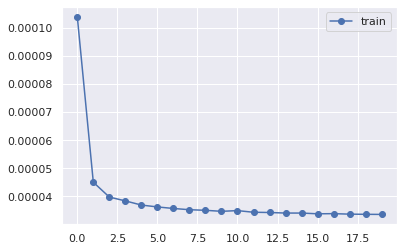

In [ ]:
val_loss_best = np.inf

# Prepare loss history
hist_loss = np.zeros(EPOCHS)
hist_loss_val = np.zeros(EPOCHS)

for idx_epoch in range(EPOCHS):
    running_loss = []
    running_loss_2 = []
    with tqdm(total=len(X_train), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for i in range(X_train.size(0)//batch_size):
            optimizer.zero_grad()

            x = X_train[i*batch_size:(i+1)*batch_size]
            y = Y_train[i*batch_size:(i+1)*batch_size]

            netout = net(x.to(device))
            loss = loss_function(y.to(device), netout)
            loss.backward()
            optimizer.step()
            running_loss.append(loss.item())

            pbar.set_postfix({'loss': np.mean(running_loss)})
            pbar.update(x.shape[0])

        # for i in range(X_val.size(0)//batch_size):
        #     x = X_val[i*batch_size:(i+1)*batch_size]
        #     y = Y_val[i*batch_size:(i+1)*batch_size]
        #     with torch.no_grad():
        #         netout = net(x.to(device))
        #     loss = loss_function(y.to(device), netout)
        #     running_loss_2.append(loss.item())

        # pbar.set_postfix({'loss': np.mean(running_loss),
        #                   'val_loss': np.mean(running_loss_2),
        #                   })
        # loss.backward()
        # optimizer.step()

        train_loss = np.mean(running_loss)
        pbar.set_postfix({'loss': np.mean(running_loss)})
        # val_loss = np.mean(running_loss_2)
        # pbar.set_postfix({'loss': train_loss, 'val_loss': val_loss})

        hist_loss[idx_epoch] = train_loss
        # hist_loss_val[idx_epoch] = val_loss

        torch.save(net.state_dict(), f"models/small_model_2_{idx_epoch+1}_epoch.pth")

        # if val_loss < val_loss_best:
        #     val_loss_best = val_loss
        #     torch.save(net.state_dict(), model_save_path)

plt.plot(hist_loss, 'o-', label='train')

# plt.plot(hist_loss_val, 'o-', label='val')
plt.legend()
# print(f"model exported to {model_save_path} with loss {val_loss_best:5f}")

# Real loss and Graph

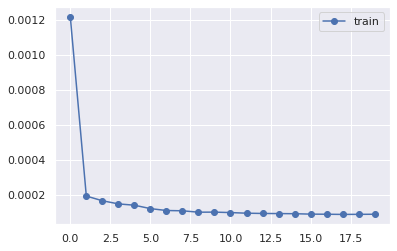

In [ ]:
plt.plot(hist_loss, 'o-', label='train')
plt.legend()
plt.savefig('small_loss_4_layer.png')

In [ ]:
x = X_val[-100:]
y = Y_val[-100:]

print(x.shape, y.shape)

pred = net(x.to(device))
pred = pred.cpu().detach()

print(pred.shape)

torch.Size([100, 25, 1]) torch.Size([100, 25, 1])
torch.Size([100, 25, 1])


In [ ]:
pred = np.reshape(pred, (pred.shape[0], pred.shape[1]))
y = np.reshape(y, (y.shape[0], y.shape[1]))

pred = [lis[-1] for lis in pred]
y = [lis[-1] for lis in y]

y = np.array(y)
pred = np.array(pred)

print(y.shape, pred.shape)

(100,) (100,)


In [ ]:
pred = np.reshape(pred, (pred.shape[0], 1))
y = np.reshape(y, (y.shape[0], 1))

pred = scaler.inverse_transform(pred)
y = scaler.inverse_transform(y)

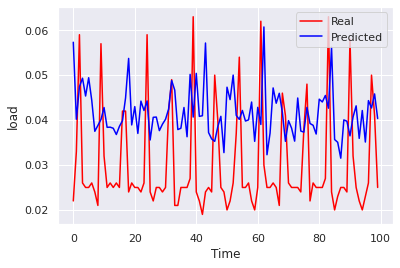

In [ ]:
plt.plot(y, color = 'Red', label = 'Real')
plt.plot(pred, color = 'Blue', label = 'Predicted')
plt.xlabel('Time')
plt.ylabel('load')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error

p = []
t = []

for i in tqdm(range(X_val.size(0))):
    x = X_val[i]
    x = np.expand_dims(x, axis=0)
    x = torch.from_numpy(x)
    with torch.no_grad():
        pred = net(x.to(device))
    pred = pred.view(pred.shape[1], pred.shape[2])
    p.append(pred.cpu().detach())

In [ ]:
p = [t.numpy() for t in p]
p = np.array(p)

pred = np.reshape(p, (p.shape[0], p.shape[1]))
y = np.reshape(Y_val, (Y_val.shape[0], Y_val.shape[1]))

pred = [lis[-1] for lis in pred]
y = [lis[-1] for lis in y]

y = np.array(y)
pred = np.array(pred)

print(y.shape, pred.shape)

In [ ]:
mse = (mean_squared_error(y, pred))
mse

In [ ]:
pred = np.reshape(pred, (pred.shape[0], 1))
y = np.reshape(y, (y.shape[0], 1))

pred = scaler.inverse_transform(pred)
y = scaler.inverse_transform(y)

mse = (mean_squared_error(y, pred))
mse

In [ ]:
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             median_absolute_error,
                            #  mean_absolute_percentage_error,
                             r2_score)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true = y_true + 1e-10
    y_pred = y_pred + 1e-10
    return np.mean(np.abs((y_true - y_pred) / (y_true))) * 100

mse = (mean_squared_error(y, pred))
rmse = mean_squared_error(y, pred, squared=False)
mae = (mean_absolute_error(y, pred))
medae = (median_absolute_error(y, pred))
r2 = (r2_score(y, pred))
mape = (mean_absolute_percentage_error(y, pred))

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("MedAE: ", medae)
print("R^2: ", r2)
print("MAPE: ", mape)

# Testing

In [ ]:
import datetime

import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import seaborn as sns

from tst import Transformer

In [ ]:
# Training parameters
batch_size = 64
NUM_WORKERS = 1
LR = 2e-4
EPOCHS = 10

# Model parameters
d_model = 64 # Lattent dim
q = 8 # Query size
v = 8 # Value size
h = 8 # Number of heads
N = 4 # Number of encoder and decoder to stack
# attention_size = 12 # Attention window size
attention_size = 12
dropout = 0.2 # Dropout rate
pe = None # Positional encoding
chunk_mode = None

d_input = 1 # From dataset
d_output = 1 # From dataset

# Config
sns.set()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda:0


In [ ]:
# Load transformer with Adam optimizer and MSE loss function
net = Transformer(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, dropout=dropout, chunk_mode=chunk_mode, pe=pe).to(device)
optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = nn.MSELoss()
# loss_function = OZELoss(alpha=0.3)

In [ ]:
import numpy as np
import pandas as pd

dfx = pd.read_csv('10TestHouses.csv')
dfx = dfx.drop(columns = ['LCLid', 'Acorn_grouped'])
dfx = dfx.reset_index(drop=True)
dfx.head()

,Unnamed: 0,KWH/hh (per half hour)
0,0,0.048
1,1,0.143
2,2,0.059
3,3,0.134
4,4,0.054


In [ ]:
dat = []
for index, row in dfx.iterrows():
    if(row['KWH/hh (per half hour) '] == 'Null'):
        row['KWH/hh (per half hour) '] = 0
    dat.append(float(row['KWH/hh (per half hour) ']))

trainset = pd.DataFrame({"KWH/hh (per half hour) " : dat})

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range = (0,1))
trainset_scaled = scaler.fit_transform(trainset)

print(len(trainset_scaled))

175301


In [ ]:
X = []
y = []

for i in range(25, len(trainset_scaled)):
    X.append(np.append(trainset_scaled[i-25:i-1, 0], 0))
    y.append(trainset_scaled[i-25:i, 0])
X, y = np.array(X), np.array(y)

X = np.reshape(X, (X.shape[0], X.shape[1], 1))
y = np.reshape(y, (y.shape[0], y.shape[1], 1))

print(X.shape)
print(y.shape)
# print(X[5])
# print(y[5])

(175276, 25, 1)
(175276, 25, 1)


In [ ]:
net.load_state_dict(torch.load("models/model_4.pth"))

<All keys matched successfully>

In [ ]:
p = []
t = []
X = torch.FloatTensor(X)
y = torch.FloatTensor(y)

for i in tqdm(range(X.size(0))):
    x = X[i]
    x = np.expand_dims(x, axis=0)
    x = torch.from_numpy(x)
    with torch.no_grad():
        pred = net(x.to(device))
    pred = pred.view(pred.shape[1], pred.shape[2])
    p.append(pred.cpu().detach())

100%|██████████| 175276/175276 [44:41<00:00, 65.37it/s]


In [ ]:
p = [t.numpy() for t in p]
p = np.array(p)

pred = np.reshape(p, (p.shape[0], p.shape[1]))
y = np.reshape(y, (y.shape[0], y.shape[1]))

pred = [lis[-1] for lis in pred]
y = [lis[-1] for lis in y]

y = np.array(y)
pred = np.array(pred)

print(y.shape)
print(pred.shape)

(175276,)
(175276,)


In [ ]:
pred = np.reshape(pred, (pred.shape[0], 1))
y = np.reshape(y, (y.shape[0], 1))

pred = scaler.inverse_transform(pred)
y = scaler.inverse_transform(y)

print(y.shape)
print(pred.shape)

(175276, 1)
(175276, 1)


In [ ]:
from sklearn.metrics import (mean_squared_error,
                             mean_absolute_error,
                             median_absolute_error,
                            #  mean_absolute_percentage_error,
                             r2_score)

def mean_absolute_percentage_error(y_true, y_pred):
    y_true = y_true + min(y_pred)
    y_pred = y_pred + min(y_pred)
    return np.mean(np.abs((y_true - y_pred) / (y_true))) * 100

mse = (mean_squared_error(y, pred))
rmse = mean_squared_error(y, pred, squared=False)
mae = (mean_absolute_error(y, pred))
medae = (median_absolute_error(y, pred))
r2 = (r2_score(y, pred))
mape = (mean_absolute_percentage_error(y, pred))

print("MSE: ", mse)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("MedAE: ", medae)
print("R^2: ", r2)
print("MAPE: ", mape)

MSE:  0.055611774
RMSE:  0.23582149
MAE:  0.12621076
MedAE:  0.06928354
R^2:  0.5608967663655948
MAPE:  77.66411900520325


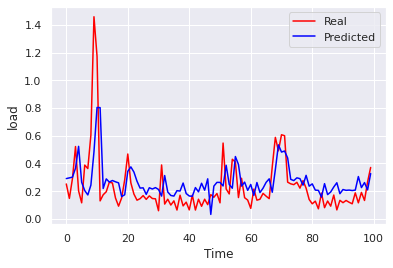

In [ ]:
plt.plot(y[1000:1100], color = 'Red', label = 'Real')
plt.plot(pred[1000:1100], color = 'Blue', label = 'Predicted')
plt.xlabel('Time')
plt.ylabel('load')
plt.legend()
plt.savefig('transformer_graph.png')
plt.show()